<a href="https://colab.research.google.com/github/Jeremy-Thompson33/BaseballSimulator/blob/main/BaseballSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Baseball Simulation**

### **Introduction**
In this notebook I will be creating a baseball game simulator with real player statistics to help answer strategical questions. I will web scrape updated player statistics from various dynamic websites using Selenium. I will then clean the data from these sites and merge the data that is necessary for simulation into a single master table. When the data is ready, I will prepare a lineup using a Player class and run a simulation using the lineup.

## Import Data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import random
import time

### Set Up Selenium

In [3]:
# Import Selenium packages
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC

In [4]:
# Set up headless Chrome options
options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

### Web Scrape Individual Hitting Stats Against LHP
*https://www.mlb.com/stats/?split=vl*

In [5]:
# Initialize WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Get URL
url = 'https://www.mlb.com/stats/?split=vl'
driver.get(url)

# Get table
table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')

# Extract headers from the table
headers = table.find_elements(By.TAG_NAME, 'th')[0:18]

# Clean headers
headers_data = [h.text for h in headers]

# Print headers
print(headers_data)

['PLAYER', 'TEAM', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']


In [7]:
"""Gets and returns the first player name in the table"""
def get_first_player_name(driver):
    table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')
    rows = table.find_elements(By.TAG_NAME, "tr")[1:]  # Skip header
    if not rows:
        return None
    try:
        player_cell = rows[0].find_element(By.TAG_NAME, 'a')
        return player_cell.get_attribute('aria-label').strip()
    except:
        return None

In [8]:
# Define the specific columns wwanted
desired_columns = ['TEAM', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'AVG', 'OBP', 'SLG']

# Get indices of desired columns
desired_indices = [(headers_data.index(col) - 1) for col in desired_columns]

In [9]:
# Extract data

all_data = []
wait = WebDriverWait(driver, 10)
previous_first_player = None

while True:
    # Re-locate table and get rows
    table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')
    rows = table.find_elements(By.TAG_NAME, 'tr')[1:]  # Skip header

    # Get the first player name in the table
    current_first_player = get_first_player_name(driver)

    # If same first player as previous page, no new data then exit
    if current_first_player == previous_first_player and previous_first_player is not None:
        print('No new page detected, exiting.')
        break

    previous_first_player = current_first_player

    # Append data from rows into all_data list
    for row in rows:
        try:
          player_name = row.find_element(By.TAG_NAME, 'a').get_attribute('aria-label').strip()
        except:
          continue


        cells = row.find_elements(By.TAG_NAME, 'td')
        if len(cells) == len(headers_data) - 1:
            row_data = [cells[i].text for i in desired_indices]
            row_data.insert(0, player_name)
            all_data.append(row_data)

    # Click Next button
    try:
        button = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="next page button"]')))
        driver.execute_script('arguments[0].scrollIntoView(true);', button)
        time.sleep(1)
        driver.execute_script('arguments[0].click();', button)

        # Wait until the first player's name changes / new page loads
        wait.until(lambda d: get_first_player_name(d) != current_first_player)

        time.sleep(1)
    except:
        print('Could not click next button or no more pages.')
        break


LHP_hitting_stats_df = pd.DataFrame(all_data, columns=['Player'] + desired_columns)
print(LHP_hitting_stats_df.head())
driver.quit()

Could not click next button or no more pages.
           Player TEAM   AB   H 2B 3B  HR  BB  SO   AVG   OBP   SLG
0     Cal Raleigh  SEA  166  46  6  0  20  14  58  .277  .337  .675
1  Kyle Schwarber  PHI  203  50  7  2  19  32  65  .246  .365  .581
2     Aaron Judge  NYY  103  34  7  0  12  31  31  .330  .481  .748
3   Shohei Ohtani  LAD  195  55  6  4  12  20  57  .282  .349  .538
4  Eugenio Suárez  SEA  136  22  4  0  12  16  47  .162  .255  .456


### Web Scrape Additional Individual Hitting Stats Against LHP

In [10]:
# Initialize WebDriver
driver = webdriver.Chrome(options=options)
wait = WebDriverWait(driver, 10)

# Get URL
driver.get(url)

# Click expanded stats button
try:
    button = wait.until(EC.element_to_be_clickable((By.XPATH, '/html/body/main/div[2]/section/section/div[1]/div[2]/div/div[1]/div/div[2]/button')))
    driver.execute_script('arguments[0].scrollIntoView(true);', button)
    time.sleep(1)
    driver.execute_script('arguments[0].click();', button)
    time.sleep(1)
except Exception as e:
    print('Could not click button:', e)

In [11]:
# Get table
table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')

# Extract headers from the table
headers = table.find_elements(By.TAG_NAME, 'th')[0:17]

# Clean headers
headers_data = [h.text for h in headers]

# Print headers
print(headers_data)

['PLAYER', 'TEAM', 'PA', 'HBP', 'SAC', 'SF', 'GIDP', 'GO/AO', 'XBH', 'TB', 'IBB', 'BABIP', 'ISO', 'AB/HR', 'BB/K', 'BB%', 'K%']


In [12]:
# Define the specific columns wwanted
desired_columns = ['TEAM', 'PA', 'HBP', 'SAC', 'SF']

# Get indices of desired columns
desired_indices = [(headers_data.index(col) - 1) for col in desired_columns]

In [13]:
# Extract data
all_data = []
previous_first_player = None

while True:
    # Re-locate table and get rows
    table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')
    rows = table.find_elements(By.TAG_NAME, 'tr')[1:]  # Skip header

    # Get the first player name in the table
    current_first_player = get_first_player_name(driver)

    # If same first player as previous page, no new data then exit
    if current_first_player == previous_first_player and previous_first_player is not None:
        print('No new page detected, exiting.')
        break

    previous_first_player = current_first_player

    # Append data from rows into all_data list
    for row in rows:
        try:
          player_name = row.find_element(By.TAG_NAME, 'a').get_attribute('aria-label').strip()
        except:
          continue


        cells = row.find_elements(By.TAG_NAME, 'td')
        if len(cells) == len(headers_data) - 1:
            row_data = [cells[i].text for i in desired_indices]
            row_data.insert(0, player_name)
            all_data.append(row_data)

    # Click Next button
    try:
        button = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="next page button"]')))
        driver.execute_script('arguments[0].scrollIntoView(true);', button)
        time.sleep(1)
        driver.execute_script('arguments[0].click();', button)

        # Wait until the first player's name changes / new page loads
        wait.until(lambda d: get_first_player_name(d) != current_first_player)

        time.sleep(1)
    except:
        print('Could not click next button or no more pages.')
        break


LHP_pa_stats_df = pd.DataFrame(all_data, columns=['Player'] + desired_columns)
print(LHP_pa_stats_df.head())
driver.quit()

Could not click next button or no more pages.
           Player TEAM   PA HBP SAC SF
0     Cal Raleigh  SEA  174   1   0  0
1  Kyle Schwarber  PHI  237   5   0  0
2     Aaron Judge  NYY  135   0   0  1
3   Shohei Ohtani  LAD  206   0   0  0
4  Eugenio Suárez  SEA   38   1   0  0


### Web Scrape Individual Hitting Stats Against RHP
*https://www.mlb.com/stats/?split=vr*

In [17]:
# Initialize WebDriver
driver = webdriver.Chrome(service=service, options=options)

# Get URL
url = 'https://www.mlb.com/stats/?split=vr'
driver.get(url)

# Get table
table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')

# Extract headers from the table
headers = table.find_elements(By.TAG_NAME, 'th')[0:18]

# Clean headers
headers_data = [h.text for h in headers]

# Print headers
print(headers_data)

['PLAYER', 'TEAM', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']


In [18]:
# Define the specific columns you want
desired_columns = ['TEAM', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'AVG', 'OBP', 'SLG']

# Get indices of desired columns
desired_indices = [(headers_data.index(col) - 1) for col in desired_columns]

In [19]:
# Extract data
all_data = []
wait = WebDriverWait(driver, 10)
previous_first_player = None

while True:
    # Re-locate table and get rows
    table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')
    rows = table.find_elements(By.TAG_NAME, 'tr')[1:]  # Skip header

    # Get the first player name in the table
    current_first_player = get_first_player_name(driver)

    # If same first player as previous page, no new data then exit
    if current_first_player == previous_first_player and previous_first_player is not None:
        print('No new page detected, exiting.')
        break

    previous_first_player = current_first_player

    # Append data from rows into all_data list
    for row in rows:
        try:
          player_name = row.find_element(By.TAG_NAME, 'a').get_attribute('aria-label').strip()
        except:
          continue


        cells = row.find_elements(By.TAG_NAME, 'td')
        if len(cells) == len(headers_data) - 1:
            row_data = [cells[i].text for i in desired_indices]
            row_data.insert(0, player_name)
            all_data.append(row_data)

    # Click Next button
    try:
        button = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="next page button"]')))
        driver.execute_script('arguments[0].scrollIntoView(true);', button)
        time.sleep(1)
        driver.execute_script('arguments[0].click();', button)

        # Wait until the first player's name changes / new page loads
        wait.until(lambda d: get_first_player_name(d) != current_first_player)

        time.sleep(1)
    except:
        print('Could not click next button or no more pages.')
        break


RHP_hitting_stats_df = pd.DataFrame(all_data, columns=['Player'] + desired_columns)
print(RHP_hitting_stats_df.head())
driver.quit()

Could not click next button or no more pages.
            Player TEAM   AB    H  2B 3B  HR  BB   SO   AVG   OBP   SLG
0    Shohei Ohtani  LAD  346   96  14  4  36  76  107  .277  .410  .653
1      Cal Raleigh  SEA  361   82  13  0  33  68  109  .227  .356  .537
2   Eugenio Suárez  SEA  377  100  21  0  33  24  118  .265  .329  .584
3      Aaron Judge  NYY  377  120  21  2  31  73  115  .318  .431  .631
4  Junior Caminero   TB  384  103  20  0  30  22   85  .268  .307  .555


### Web Scrape Additional Individual Hitting Stats Against RHP

In [20]:
# Initialize WebDriver
driver = webdriver.Chrome(service=service, options=options)
wait = WebDriverWait(driver, 10)

# Get URL
driver.get(url)

# Click expanded stats button
try:
    button = wait.until(EC.element_to_be_clickable((By.XPATH, '/html/body/main/div[2]/section/section/div[1]/div[2]/div/div[1]/div/div[2]/button')))
    driver.execute_script('arguments[0].scrollIntoView(true);', button)
    time.sleep(1)
    driver.execute_script('arguments[0].click();', button)
    time.sleep(1)
except Exception as e:
    print('Could not click button:', e)

In [21]:
# Get table
table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')

# Extract headers from the table
headers = table.find_elements(By.TAG_NAME, 'th')[0:17]

# Clean headers
headers_data = [h.text for h in headers]

# Print headers
print(headers_data)

['PLAYER', 'TEAM', 'PA', 'HBP', 'SAC', 'SF', 'GIDP', 'GO/AO', 'XBH', 'TB', 'IBB', 'BABIP', 'ISO', 'AB/HR', 'BB/K', 'BB%', 'K%']


In [22]:
# Define the specific columns wwanted
desired_columns = ['TEAM', 'PA', 'HBP', 'SAC', 'SF']

# Get indices of desired columns
desired_indices = [(headers_data.index(col) - 1) for col in desired_columns]

In [23]:
# Extract data
all_data = []
previous_first_player = None

while True:
    # Re-locate table and get rows
    table = driver.find_element(By.XPATH, '//*[@id="stats-app-root"]/section/section/div[4]/div[1]/div/table')
    rows = table.find_elements(By.TAG_NAME, 'tr')[1:]  # Skip header

    # Get the first player name in the table
    current_first_player = get_first_player_name(driver)

    # If same first player as previous page, no new data then exit
    if current_first_player == previous_first_player and previous_first_player is not None:
        print('No new page detected, exiting.')
        break

    previous_first_player = current_first_player

    # Append data from rows into all_data list
    for row in rows:
          try:
            player_name = row.find_element(By.TAG_NAME, 'a').get_attribute('aria-label').strip()
          except:
            continue


          cells = row.find_elements(By.TAG_NAME, 'td')
          if len(cells) == len(headers_data) - 1:
              row_data = [cells[i].text for i in desired_indices]
              row_data.insert(0, player_name)
              all_data.append(row_data)

    # Click Next button
    try:
        button = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="next page button"]')))  # wait until old row becomes stale

        # wait.until(EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="next page button"]')))
        driver.execute_script('arguments[0].scrollIntoView(true);', button)
        time.sleep(1)
        driver.execute_script('arguments[0].click();', button)

        # Wait until the first player's name changes / new page loads
        wait.until(lambda d: get_first_player_name(d) != current_first_player)

        time.sleep(1)
    except:
        print('Could not click next button or no more pages.')
        break


RHP_pa_stats_df = pd.DataFrame(all_data, columns=['Player'] + desired_columns)
print(RHP_pa_stats_df.head())
driver.quit()

Could not click next button or no more pages.
            Player TEAM   PA HBP SAC SF
0    Shohei Ohtani  LAD  413   3   0  2
1      Cal Raleigh  SEA  429   6   0  3
2   Eugenio Suárez  SEA   86   0   0  1
3      Aaron Judge  NYY  444   5   0  4
4  Junior Caminero   TB  406   1   0  4


### Web Scrape for Advanced Hitting Statistics
*https://baseballsavant.mlb.com/leaderboard/batted-ball?gameType=Regular&minSwings=50&minGroupSwings=1&seasonStart=2025&seasonEnd=2025&type=batter&sortColumn=pull_air_rate&sortDirection=desc*

In [25]:
# Initialize WebDriver
driver = webdriver.Chrome(service=service, options=options)

# Get website URL
url = 'https://baseballsavant.mlb.com/leaderboard/batted-ball?gameType=Regular&minSwings=50&minGroupSwings=1&seasonStart=2025&seasonEnd=2025&type=batter&sortColumn=pull_air_rate&sortDirection=desc'
driver.get(url)

# Locate the table by its class name
table = driver.find_element(By.CLASS_NAME, 'table-savant')

# Extract headers from the table
headers = table.find_elements(By.TAG_NAME, 'th')[6:24]

# Clean headers
headers_data = [h.text.replace(' ', '').replace('\n', '') for h in headers]

# Print headers
print(headers_data)

['Rk.', 'Player', 'Team', 'BBE', 'GB%', 'AIR%', 'FB%', 'LD%', 'PU%', 'Pull%', 'Straight%', 'Oppo%', 'PullGB%', 'StraightGB%', 'OppoGB%', 'PullAIR%', 'StraightAIR%', 'OppoAIR%']


In [ ]:
# Extract all the rows from the table
rows = table.find_elements(By.CLASS_NAME, 'default-table-row')

# Extract data from rows and add it to the data list
data = []

for row in rows:
    row_data = row.find_elements(By.TAG_NAME, 'td')
    individual_row_data = [cell.text.strip() for cell in row_data]
    data.append(individual_row_data)

driver.quit()

# Create DataFrame with headers and data lists
batted_ball_event_df = pd.DataFrame(data, columns=headers_data)

# Print dataframe
batted_ball_event_df.head()

,Rk.,Player,Team,BBE,GB%,AIR%,FB%,LD%,PU%,Pull%,Straight%,Oppo%,PullGB%,StraightGB%,OppoGB%,PullAIR%,StraightAIR%,OppoAIR%
0,1,"Raleigh, Cal",,359,25.1%,74.9%,43.2%,18.4%,13.4%,54.9%,25.1%,20.1%,15.9%,6.1%,3.1%,39.0%,18.9%,17.0%
1,2,"Melendez, MJ",,37,32.4%,67.6%,40.5%,13.5%,13.5%,62.2%,27.0%,10.8%,24.3%,8.1%,0.0%,37.8%,18.9%,10.8%
2,3,"Paredes, Isaac",,286,31.1%,68.9%,32.5%,25.5%,10.8%,56.3%,26.9%,16.8%,18.9%,8.0%,4.2%,37.4%,18.9%,12.6%
3,4,"Schneider, Davis",,100,26.0%,74.0%,41.0%,17.0%,16.0%,54.0%,34.0%,12.0%,18.0%,8.0%,0.0%,36.0%,26.0%,12.0%
4,5,"Hoskins, Rhys",,190,29.5%,70.5%,34.2%,25.8%,10.5%,52.1%,33.2%,14.7%,16.8%,10.0%,2.6%,35.3%,23.2%,12.1%


## Clean Data

In [27]:
import unicodedata

# Strips strings of accents
def remove_accents(text):
    if isinstance(text, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', text)
            if unicodedata.category(c) != 'Mn'
        )
    return text

### Clean LHP Hitting Stats Dataframes

In [28]:
# Merge hitting stats against LHP and additional hitting stats against LHP dataframes
full_LHP_hitting_stats_df = pd.merge(LHP_hitting_stats_df, LHP_pa_stats_df, how='left', on=['Player', 'TEAM'])

# Get info
full_LHP_hitting_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Player  641 non-null    object
 1   TEAM    641 non-null    object
 2   AB      641 non-null    object
 3   H       641 non-null    object
 4   2B      641 non-null    object
 5   3B      641 non-null    object
 6   HR      641 non-null    object
 7   BB      641 non-null    object
 8   SO      641 non-null    object
 9   AVG     641 non-null    object
 10  OBP     641 non-null    object
 11  SLG     641 non-null    object
 12  PA      641 non-null    object
 13  HBP     641 non-null    object
 14  SAC     641 non-null    object
 15  SF      641 non-null    object
dtypes: object(16)
memory usage: 80.3+ KB


In [98]:
# Change header names
full_LHP_hitting_stats_df.columns = ['Player'] + ['Team'] + [col + '_LHP' if not col.endswith('LHP') else col for col in full_LHP_hitting_stats_df.columns[2:]]

# Print dataframe
full_LHP_hitting_stats_df.head()

,Player,Team,AB_LHP,H_LHP,2B_LHP,3B_LHP,HR_LHP,BB_LHP,SO_LHP,AVG_LHP,OBP_LHP,SLG_LHP,PA_LHP,HBP_LHP,SAC_LHP,SF_LHP
0,Cal Raleigh,SEA,166,46,6,0,20,14,58,0.277,0.337,0.675,174,1,0,0
1,Kyle Schwarber,PHI,203,50,7,2,19,32,65,0.246,0.365,0.581,237,5,0,0
2,Aaron Judge,NYY,103,34,7,0,12,31,31,0.330,0.481,0.748,135,0,0,1
3,Shohei Ohtani,LAD,195,55,6,4,12,20,57,0.282,0.349,0.538,206,0,0,0
4,Eugenio Suarez,SEA,136,22,4,0,12,16,47,0.162,0.255,0.456,38,1,0,0


In [30]:
# Change datatypes of columns
for col in full_LHP_hitting_stats_df.columns[2:]:
    full_LHP_hitting_stats_df[col] = (pd.to_numeric(full_LHP_hitting_stats_df[col], errors='coerce'))

# Print dataframe
full_LHP_hitting_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   641 non-null    object 
 1   Team     641 non-null    object 
 2   AB_LHP   641 non-null    int64  
 3   H_LHP    641 non-null    int64  
 4   2B_LHP   641 non-null    int64  
 5   3B_LHP   641 non-null    int64  
 6   HR_LHP   641 non-null    int64  
 7   BB_LHP   641 non-null    int64  
 8   SO_LHP   641 non-null    int64  
 9   AVG_LHP  641 non-null    float64
 10  OBP_LHP  641 non-null    float64
 11  SLG_LHP  641 non-null    float64
 12  PA_LHP   641 non-null    int64  
 13  HBP_LHP  641 non-null    int64  
 14  SAC_LHP  641 non-null    int64  
 15  SF_LHP   641 non-null    int64  
dtypes: float64(3), int64(11), object(2)
memory usage: 80.3+ KB


In [31]:
# Remove accents from player names
full_LHP_hitting_stats_df['Player'] = full_LHP_hitting_stats_df['Player'].apply(remove_accents)

In [32]:
# Distinguish Athletics Max Muncy from Dodgers Max Muncy
full_LHP_hitting_stats_df.loc[(full_LHP_hitting_stats_df['Player'] == 'Max Muncy') & (full_LHP_hitting_stats_df['Team'] == 'ATH'), 'Player'] = 'Max Muncy ATH'

### Clean RHP Hitting Stats Dataframes

In [33]:
# Merge hitting stats against LHP and additional hitting stats against LHP dataframes
full_RHP_hitting_stats_df = pd.merge(RHP_hitting_stats_df, RHP_pa_stats_df, how='left', on=['Player', 'TEAM'])

# Get info
full_RHP_hitting_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Player  649 non-null    object
 1   TEAM    649 non-null    object
 2   AB      649 non-null    object
 3   H       649 non-null    object
 4   2B      649 non-null    object
 5   3B      649 non-null    object
 6   HR      649 non-null    object
 7   BB      649 non-null    object
 8   SO      649 non-null    object
 9   AVG     649 non-null    object
 10  OBP     649 non-null    object
 11  SLG     649 non-null    object
 12  PA      649 non-null    object
 13  HBP     649 non-null    object
 14  SAC     649 non-null    object
 15  SF      649 non-null    object
dtypes: object(16)
memory usage: 81.3+ KB


In [ ]:
# Change header names
full_RHP_hitting_stats_df.columns = ['Player'] + ['Team'] + [col + '_RHP' if not col.endswith('RHP') else col for col in full_RHP_hitting_stats_df.columns[2:]]

# Print dataframe
full_RHP_hitting_stats_df.head()

            Player Team AB_RHP H_RHP 2B_RHP 3B_RHP HR_RHP BB_RHP SO_RHP  \
0    Shohei Ohtani  LAD    346    96     14      4     36     76    107   
1      Cal Raleigh  SEA    361    82     13      0     33     68    109   
2   Eugenio Suárez  SEA    377   100     21      0     33     24    118   
3      Aaron Judge  NYY    377   120     21      2     31     73    115   
4  Junior Caminero   TB    384   103     20      0     30     22     85   

  AVG_RHP OBP_RHP SLG_RHP PA_RHP HBP_RHP SAC_RHP SF_RHP  
0    .277    .410    .653    413       3       0      2  
1    .227    .356    .537    429       6       0      3  
2    .265    .329    .584     86       0       0      1  
3    .318    .431    .631    444       5       0      4  
4    .268    .307    .555    406       1       0      4  


In [35]:
# Change datatypes of columns
for col in full_RHP_hitting_stats_df.columns[2:]:
    full_RHP_hitting_stats_df[col] = (pd.to_numeric(full_RHP_hitting_stats_df[col], errors='coerce'))

# Print dataframe
full_RHP_hitting_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   649 non-null    object 
 1   Team     649 non-null    object 
 2   AB_RHP   649 non-null    int64  
 3   H_RHP    649 non-null    int64  
 4   2B_RHP   649 non-null    int64  
 5   3B_RHP   649 non-null    int64  
 6   HR_RHP   649 non-null    int64  
 7   BB_RHP   649 non-null    int64  
 8   SO_RHP   649 non-null    int64  
 9   AVG_RHP  649 non-null    float64
 10  OBP_RHP  649 non-null    float64
 11  SLG_RHP  649 non-null    float64
 12  PA_RHP   649 non-null    int64  
 13  HBP_RHP  649 non-null    int64  
 14  SAC_RHP  649 non-null    int64  
 15  SF_RHP   649 non-null    int64  
dtypes: float64(3), int64(11), object(2)
memory usage: 81.3+ KB


In [36]:
# Remove accents from player names
full_RHP_hitting_stats_df['Player'] = full_RHP_hitting_stats_df['Player'].apply(remove_accents)

In [37]:
# Distinguish Athletics Max Muncy from Dodgers Max Muncy
full_RHP_hitting_stats_df.loc[(full_RHP_hitting_stats_df['Player'] == 'Max Muncy') & (full_RHP_hitting_stats_df['Team'] == 'ATH'), 'Player'] = 'Max Muncy ATH'

In [38]:
# Drop team column before merge
full_RHP_hitting_stats_df.drop('Team',  axis=1, inplace=True)

### Clean Batted Ball Event Dataframe

In [39]:
# Drop uneccesary columns
batted_ball_event_df.drop('Rk.', axis=1, inplace=True)

batted_ball_event_df.drop('Team', axis=1, inplace=True)

In [40]:
# Change format of 'Player' column
batted_ball_event_df['Player'] = batted_ball_event_df['Player'].apply(lambda x: x.split(', ')[1] + ' ' + x.split(', ')[0] if ', ' in x else x)

# Print dataframe
batted_ball_event_df.head()

,Player,BBE,GB%,AIR%,FB%,LD%,PU%,Pull%,Straight%,Oppo%,PullGB%,StraightGB%,OppoGB%,PullAIR%,StraightAIR%,OppoAIR%
0,Cal Raleigh,359,25.1%,74.9%,43.2%,18.4%,13.4%,54.9%,25.1%,20.1%,15.9%,6.1%,3.1%,39.0%,18.9%,17.0%
1,MJ Melendez,37,32.4%,67.6%,40.5%,13.5%,13.5%,62.2%,27.0%,10.8%,24.3%,8.1%,0.0%,37.8%,18.9%,10.8%
2,Isaac Paredes,286,31.1%,68.9%,32.5%,25.5%,10.8%,56.3%,26.9%,16.8%,18.9%,8.0%,4.2%,37.4%,18.9%,12.6%
3,Davis Schneider,100,26.0%,74.0%,41.0%,17.0%,16.0%,54.0%,34.0%,12.0%,18.0%,8.0%,0.0%,36.0%,26.0%,12.0%
4,Rhys Hoskins,190,29.5%,70.5%,34.2%,25.8%,10.5%,52.1%,33.2%,14.7%,16.8%,10.0%,2.6%,35.3%,23.2%,12.1%


In [41]:
# Remove accents from player names
batted_ball_event_df['Player'] = batted_ball_event_df['Player'].apply(remove_accents)

In [42]:
# Change format of columns containing percent symbols
for col in batted_ball_event_df.columns:
    if batted_ball_event_df[col].dtype == 'object' and batted_ball_event_df[col].str.contains('%').any():
        batted_ball_event_df[col] = (pd.to_numeric(batted_ball_event_df[col].str.replace('%', '', regex=False), errors='coerce') / 100).round(3)

# Print dataframe
batted_ball_event_df.head()

,Player,BBE,GB%,AIR%,FB%,LD%,PU%,Pull%,Straight%,Oppo%,PullGB%,StraightGB%,OppoGB%,PullAIR%,StraightAIR%,OppoAIR%
0,Cal Raleigh,359,0.251,0.749,0.432,0.184,0.134,0.549,0.251,0.201,0.159,0.061,0.031,0.390,0.189,0.170
1,MJ Melendez,37,0.324,0.676,0.405,0.135,0.135,0.622,0.270,0.108,0.243,0.081,0.000,0.378,0.189,0.108
2,Isaac Paredes,286,0.311,0.689,0.325,0.255,0.108,0.563,0.269,0.168,0.189,0.080,0.042,0.374,0.189,0.126
3,Davis Schneider,100,0.260,0.740,0.410,0.170,0.160,0.540,0.340,0.120,0.180,0.080,0.000,0.360,0.260,0.120
4,Rhys Hoskins,190,0.295,0.705,0.342,0.258,0.105,0.521,0.332,0.147,0.168,0.100,0.026,0.353,0.232,0.121


In [43]:
# Make BBE int data type
batted_ball_event_df['BBE'] = pd.to_numeric(batted_ball_event_df['BBE'], errors='coerce').fillna(0).astype(int)

In [44]:
# Distinguish Athletics Max Muncy from Dodgers Max Muncy
muncy_rows = batted_ball_event_df.loc[batted_ball_event_df['Player'] == 'Max Muncy']

if len(muncy_rows) >= 2:
    # Find index of row with lower 'PullAir%'
    lower_index = muncy_rows['PullAIR%'].idxmin()

    # Rename that row to 'Max MuncyA'
    batted_ball_event_df.loc[lower_index, 'Player'] = 'Max Muncy ATH'

### Merge Dataframes

In [45]:
# Left merge dataframes on 'Player' column
master_hitting_stats_df = batted_ball_event_df.merge(full_LHP_hitting_stats_df, how='left', on='Player').merge(full_RHP_hitting_stats_df, how='left', on='Player')

# Print dataframe sample
master_hitting_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        511 non-null    object 
 1   BBE           511 non-null    int32  
 2   GB%           511 non-null    float64
 3   AIR%          511 non-null    float64
 4   FB%           511 non-null    float64
 5   LD%           511 non-null    float64
 6   PU%           511 non-null    float64
 7   Pull%         511 non-null    float64
 8   Straight%     511 non-null    float64
 9   Oppo%         511 non-null    float64
 10  PullGB%       511 non-null    float64
 11  StraightGB%   511 non-null    float64
 12  OppoGB%       511 non-null    float64
 13  PullAIR%      511 non-null    float64
 14  StraightAIR%  511 non-null    float64
 15  OppoAIR%      511 non-null    float64
 16  Team          511 non-null    object 
 17  AB_LHP        511 non-null    int64  
 18  H_LHP         511 non-null    

### Clean Merged Dataframe

In [46]:
# Replace remaining NaN with 0
for col in master_hitting_stats_df.columns:
      master_hitting_stats_df[col] = master_hitting_stats_df[col].fillna(0)

master_hitting_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        511 non-null    object 
 1   BBE           511 non-null    int32  
 2   GB%           511 non-null    float64
 3   AIR%          511 non-null    float64
 4   FB%           511 non-null    float64
 5   LD%           511 non-null    float64
 6   PU%           511 non-null    float64
 7   Pull%         511 non-null    float64
 8   Straight%     511 non-null    float64
 9   Oppo%         511 non-null    float64
 10  PullGB%       511 non-null    float64
 11  StraightGB%   511 non-null    float64
 12  OppoGB%       511 non-null    float64
 13  PullAIR%      511 non-null    float64
 14  StraightAIR%  511 non-null    float64
 15  OppoAIR%      511 non-null    float64
 16  Team          511 non-null    object 
 17  AB_LHP        511 non-null    int64  
 18  H_LHP         511 non-null    

In [47]:
# Print dataframe
master_hitting_stats_df.head()

,Player,BBE,GB%,AIR%,FB%,LD%,PU%,Pull%,Straight%,Oppo%,...,HR_RHP,BB_RHP,SO_RHP,AVG_RHP,OBP_RHP,SLG_RHP,PA_RHP,HBP_RHP,SAC_RHP,SF_RHP
0,Cal Raleigh,359,0.251,0.749,0.432,0.184,0.134,0.549,0.251,0.201,...,33.0,68.0,109.0,0.227,0.356,0.537,429.0,6.0,0.0,3.0
1,MJ Melendez,37,0.324,0.676,0.405,0.135,0.135,0.622,0.270,0.108,...,0.0,2.0,20.0,0.077,0.111,0.115,54.0,0.0,0.0,0.0
2,Isaac Paredes,286,0.311,0.689,0.325,0.255,0.108,0.563,0.269,0.168,...,16.0,40.0,58.0,0.269,0.364,0.486,341.0,5.0,0.0,2.0
3,Davis Schneider,100,0.260,0.740,0.410,0.170,0.160,0.540,0.340,0.120,...,6.0,9.0,19.0,0.238,0.333,0.540,72.0,0.0,0.0,0.0
4,Rhys Hoskins,190,0.295,0.705,0.342,0.258,0.105,0.521,0.332,0.147,...,8.0,24.0,61.0,0.245,0.339,0.426,221.0,5.0,0.0,4.0


## Download Master Hitting Stats Table as csv

In [ ]:
# Download dataframe as a csv (so I don't have to scrape all the data everytime)
master_hitting_stats_df.to_csv('C:\\Users\\jftho\\OneDrive\\Documents\\Personal Data Analytics\\Baseball Simulator\\mlb_hitting_stats.csv', index=False)

In [ ]:
# Import csv file to use
master_hitting_stats_df = pd.read_csv('C:\\Users\\jftho\\OneDrive\\Documents\\Personal Data Analytics\\Baseball Simulator\\mlb_hitting_stats.csv')

,Player,BBE,GB%,AIR%,FB%,LD%,PU%,Pull%,Straight%,Oppo%,...,HR_RHP,BB_RHP,SO_RHP,AVG_RHP,OBP_RHP,SLG_RHP,PA_RHP,HBP_RHP,SAC_RHP,SF_RHP
0,Cal Raleigh,359,0.251,0.749,0.432,0.184,0.134,0.549,0.251,0.201,...,33.0,68.0,109.0,0.227,0.356,0.537,429.0,6.0,0.0,3.0
1,MJ Melendez,37,0.324,0.676,0.405,0.135,0.135,0.622,0.270,0.108,...,0.0,2.0,20.0,0.077,0.111,0.115,54.0,0.0,0.0,0.0
2,Isaac Paredes,286,0.311,0.689,0.325,0.255,0.108,0.563,0.269,0.168,...,16.0,40.0,58.0,0.269,0.364,0.486,341.0,5.0,0.0,2.0
3,Davis Schneider,100,0.260,0.740,0.410,0.170,0.160,0.540,0.340,0.120,...,6.0,9.0,19.0,0.238,0.333,0.540,72.0,0.0,0.0,0.0
4,Rhys Hoskins,190,0.295,0.705,0.342,0.258,0.105,0.521,0.332,0.147,...,8.0,24.0,61.0,0.245,0.339,0.426,221.0,5.0,0.0,4.0


## Create Classes

### Player Class

In [51]:
class Player:
    def __init__(self, name,
                 plate_apps_rhp, at_bats_rhp, singles_rhp, doubles_rhp, triples_rhp, home_runs_rhp,
                 OBP_rhp, SLG_rhp, strikeouts_rhp, walks_rhp, sac_bunts_rhp, sac_flies_rhp, hbp_rhp,
                 plate_apps_lhp, at_bats_lhp, singles_lhp, doubles_lhp, triples_lhp, home_runs_lhp,
                 OBP_lhp, SLG_lhp, strikeouts_lhp, walks_lhp, sac_bunts_lhp, sac_flies_lhp, hbp_lhp,
                 pull_oppo_GB_pct, middle_GB_pct):

        self.name = name

        # vs RHP
        self.plate_apps_rhp = plate_apps_rhp
        self.at_bats_rhp = at_bats_rhp
        self.singles_rhp = singles_rhp
        self.doubles_rhp = doubles_rhp
        self.triples_rhp = triples_rhp
        self.home_runs_rhp = home_runs_rhp
        self.OBP_rhp = OBP_rhp
        self.SLG_rhp = SLG_rhp
        self.strikeouts_rhp = strikeouts_rhp
        self.walks_rhp = walks_rhp
        self.sac_bunts_rhp = sac_bunts_rhp
        self.sac_flies_rhp = sac_flies_rhp
        self.hbp_rhp = hbp_rhp

        # vs LHP
        self.plate_apps_lhp = plate_apps_lhp
        self.at_bats_lhp = at_bats_lhp
        self.singles_lhp = singles_lhp
        self.doubles_lhp = doubles_lhp
        self.triples_lhp = triples_lhp
        self.home_runs_lhp = home_runs_lhp
        self.OBP_lhp = OBP_lhp
        self.SLG_lhp = SLG_lhp
        self.strikeouts_lhp = strikeouts_lhp
        self.walks_lhp = walks_lhp
        self.sac_bunts_lhp = sac_bunts_lhp
        self.sac_flies_lhp = sac_flies_lhp
        self.hbp_lhp = hbp_lhp

        # Groundball splits
        self.pull_oppo_GB_pct = pull_oppo_GB_pct
        self.middle_GB_pct = middle_GB_pct

    # --- Rate Calculations ---
    def find_single_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        singles = self.singles_rhp if vs == 'rhp' else self.singles_lhp
        return round(singles / pa, 3) if pa > 0 else 0

    def find_double_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        doubles = self.doubles_rhp if vs == 'rhp' else self.doubles_lhp
        return round(doubles / pa, 3) if pa > 0 else 0

    def find_triple_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        triples = self.triples_rhp if vs == 'rhp' else self.triples_lhp
        return round(triples / pa, 3) if pa > 0 else 0

    def find_HR_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        hr = self.home_runs_rhp if vs == 'rhp' else self.home_runs_lhp
        return round(hr / pa, 3) if pa > 0 else 0

    def find_walk_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        walks = self.walks_rhp if vs == 'rhp' else self.walks_lhp
        return round(walks / pa, 3) if pa > 0 else 0

    def find_sac_bunt_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        sacs = self.sac_bunts_rhp if vs == 'rhp' else self.sac_bunts_lhp
        return round(sacs / pa, 4) if pa > 0 else 0

    def find_sac_fly_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        sacs = self.sac_flies_rhp if vs == 'rhp' else self.sac_flies_lhp
        return round(sacs / pa, 4) if pa > 0 else 0

    def find_hbp_rate(self, vs='rhp'):
        pa = self.plate_apps_rhp - self.sac_bunts_rhp if vs == 'rhp' else self.plate_apps_lhp - self.sac_bunts_lhp
        hbp = self.hbp_rhp if vs == 'rhp' else self.hbp_lhp
        return round(hbp / pa, 4) if pa > 0 else 0

    # --- Display ---
    def __str__(self):
        return (f"Player: {self.name}\n"
                f"--- vs RHP ---\n"
                f"PA: {self.plate_apps_rhp}, AB: {self.at_bats_rhp}, BB: {self.walks_rhp}, K: {self.strikeouts_rhp}, "
                f"SH: {self.sac_bunts_rhp + self.sac_flies_rhp}, HBP: {self.hbp_rhp}\n"
                f"1B: {self.singles_rhp}, 2B: {self.doubles_rhp}, 3B: {self.triples_rhp}, HR: {self.home_runs_rhp}\n"
                f"OBP: {self.OBP_rhp}, SLG: {self.SLG_rhp}\n"
                f"--- vs LHP ---\n"
                f"PA: {self.plate_apps_lhp}, AB: {self.at_bats_lhp}, BB: {self.walks_lhp}, K: {self.strikeouts_lhp}, "
                f"SH: {self.sac_bunts_lhp + self.sac_flies_lhp}, HBP: {self.hbp_lhp}\n"
                f"1B: {self.singles_lhp}, 2B: {self.doubles_lhp}, 3B: {self.triples_lhp}, HR: {self.home_runs_lhp}\n"
                f"OBP: {self.OBP_lhp}, SLG: {self.SLG_lhp}\n"
                f"Groundball Pct (Pull/Oppo): {self.pull_oppo_GB_pct}, Middle: {self.middle_GB_pct}")

    def print_player(self):
        return f"->   {self.name}      PAs: {self.plate_apps_lhp + self.plate_apps_rhp}"

### BaseRunners Class

In [52]:
# Create BaseRunners class
class BaseRunners:
    def __init__(self):
        # [First base, Second base, Third base]
        self.bases = [None, None, None]
        self.next_runner_id = 1  # simple ID to track runners

    def add_runner(self, base_number):
        """Adds a new batter to given base."""
        if 1 <= base_number <= 3:
          self.bases[base_number - 1] = self.next_runner_id
          self.next_runner_id += 1

    def advance_runners(self, bases_to_advance):
        """Advances all runners the given number of bases."""
        new_bases = [None, None, None]
        runs = 0

        for i in reversed(range(3)):
            runner = self.bases[i]
            if runner is not None:
                new_position = i + bases_to_advance
                if new_position >= 3:
                    runs += 1  # runner scores
                else:
                    new_bases[new_position] = runner

        # Add the new batter (as a new runner) to first base
        if bases_to_advance >= 4:
            runs += 1
        elif bases_to_advance > 0:
            new_bases[bases_to_advance - 1] = self.next_runner_id
            self.next_runner_id += 1

        self.bases = new_bases
        return runs

    def reset_bases(self):
      """Resets the bases"""
      self.bases = [None, None, None]

    def __str__(self):
        return f"1B: {self.bases[0]}, 2B: {self.bases[1]}, 3B: {self.bases[2]}"

    def is_runner_on_first(self):
        return self.bases[0] is not None

    def is_runner_on_second(self):
      return self.bases[1] is not None

    def is_runner_on_third(self):
      return self.bases[2] is not None

    def walk_runner(self):
      """Handles walking a batter — forces runners to advance if needed."""
      runs = 0

      # If all bases are full, walking a batter scores a run
      if self.bases[0] and self.bases[1] and self.bases[2]:
          runs += 1

          self.bases[2] = self.bases[1]
          self.bases[1] = self.bases[0]
          self.bases[0] = self.next_runner_id
          self.next_runner_id += 1

      elif self.bases[0] and self.bases[1]:
          # If first and second occupied, shift to second and third
          self.bases[2] = self.bases[1]
          self.bases[1] = self.bases[0]
          self.bases[0] = self.next_runner_id
          self.next_runner_id += 1

      elif self.bases[0]:  # Only first base occupied, runner to second
          self.bases[1] = self.bases[0]
          self.bases[0] = self.next_runner_id
          self.next_runner_id += 1

      else: # No one on first, batter just goes to first
          self.bases[0] = self.next_runner_id
          self.next_runner_id += 1

      return runs

    def runner_scores_from_third(self):
      if self.bases[2] is not None:
          runner_id = self.bases[2]
          self.bases[2] = None
          return 1
      return 0




## Testing and Simulation

In [53]:
"""Returns a list of players from a team as Player objects"""
def get_players(team):

  players = master_hitting_stats_df[master_hitting_stats_df['Team'] == team]   # Get all players from given team

  players_list = []   # Create list for players

  # Create a player object for each player
  for index, row in players.iterrows():
    player = Player(
        # RHP
        row['Player'],
        row['PA_RHP'],  # plate appearances
        row['AB_RHP'], # at-bats
        (row['H_RHP'] - row['2B_RHP'] - row['3B_RHP'] - row['HR_RHP']),  # singles
        row['2B_RHP'],
        row['3B_RHP'],
        row['HR_RHP'],
        row['OBP_RHP'],
        row['SLG_RHP'],
        row['SO_RHP'],
        row['BB_RHP'],
        row['SAC_RHP'],  # sac bunts
        row['SF_RHP'],   # sac flies
        row['HBP_RHP'],  # hit by pitch
        # LHP
        row['PA_LHP'],  # plate appearances
        row['AB_LHP'], # at-bats
        (row['H_LHP'] - row['2B_LHP'] - row['3B_LHP'] - row['HR_LHP']),  # singles
        row['2B_LHP'],
        row['3B_LHP'],
        row['HR_LHP'],
        row['OBP_LHP'],
        row['SLG_LHP'],
        row['SO_LHP'],
        row['BB_LHP'],
        row['SAC_LHP'],  # sac bunts
        row['SF_LHP'],   # sac flies
        row['HBP_LHP'],  # hit by pitch

        round((row['PullGB%'] + row['OppoGB%']), 3),
        row['StraightGB%']
    )

    players_list.append(player) # Add player to list
    players_list.sort(key=lambda p: p.name) # Sort players alphabetically

  return players_list

In [54]:
"""Prints all the players in a list"""
def print_players(list):
  index = 0
  for p in list:
    print(f"-   {p.name}      PAs: {(p.plate_apps_rhp + p.plate_apps_rhp)}     RHP OBP: {p.OBP_rhp}      LHP OBP: {p.OBP_lhp}      Index: {index}")
    index += 1

### Set Phillies Lineups

In [55]:
# Get the players from the Phillies
phillies_hitters = get_players("PHI")

# Print the players in the list
print_players(phillies_hitters)

-   Alec Bohm      PAs: 658.0     RHP OBP: 0.315      LHP OBP: 0.331      Index: 0
-   Brandon Marsh      PAs: 576.0     RHP OBP: 0.358      LHP OBP: 0.292      Index: 1
-   Bryce Harper      PAs: 600.0     RHP OBP: 0.368      LHP OBP: 0.332      Index: 2
-   Bryson Stott      PAs: 764.0     RHP OBP: 0.33      LHP OBP: 0.293      Index: 3
-   Edmundo Sosa      PAs: 252.0     RHP OBP: 0.254      LHP OBP: 0.37      Index: 4
-   Harrison Bader      PAs: 438.0     RHP OBP: 0.371      LHP OBP: 0.3      Index: 5
-   J.T. Realmuto      PAs: 672.0     RHP OBP: 0.356      LHP OBP: 0.252      Index: 6
-   Johan Rojas      PAs: 194.0     RHP OBP: 0.274      LHP OBP: 0.288      Index: 7
-   Kyle Schwarber      PAs: 774.0     RHP OBP: 0.367      LHP OBP: 0.365      Index: 8
-   Max Kepler      PAs: 710.0     RHP OBP: 0.31      LHP OBP: 0.25      Index: 9
-   Nick Castellanos      PAs: 742.0     RHP OBP: 0.297      LHP OBP: 0.295      Index: 10
-   Otto Kemp      PAs: 218.0     RHP OBP: 0.284      L

In [56]:
# Create list for starting lineup
phillies_lineup_rhp = []

# Set lineup based on indexes from above code block
phillies_lineup_rhp.extend([phillies_hitters[13], phillies_hitters[8], phillies_hitters[2],
                            phillies_hitters[6], phillies_hitters[0], phillies_hitters[1],
                            phillies_hitters[5], phillies_hitters[7], phillies_hitters[3]])

# Create list for starting lineup
phillies_lineup_lhp = []

# Set lineup based on indexes from above code block
phillies_lineup_lhp.extend([phillies_hitters[13], phillies_hitters[8], phillies_hitters[2],
                            phillies_hitters[6], phillies_hitters[0], phillies_hitters[1],
                            phillies_hitters[5], phillies_hitters[7], phillies_hitters[3]])

Testing

In [57]:
test_player = phillies_hitters[2]

print(test_player)

Player: Bryce Harper
--- vs RHP ---
PA: 300.0, AB: 260.0, BB: 43.0, K: 61.0, SH: 3.0, HBP: 4.0
1B: 33.0, 2B: 19.0, 3B: 0.0, HR: 15.0
OBP: 0.368, SLG: 0.504
--- vs LHP ---
PA: 192, AB: 180, BB: 15, K: 45, SH: 0, HBP: 1
1B: 29, 2B: 11, 3B: 0, HR: 9
OBP: 0.332, SLG: 0.483
Groundball Pct (Pull/Oppo): 0.273, Middle: 0.159


### Create Simulator Functions

In [67]:
"""Simulates a game against an average RHP"""
def right_hander_sim(innings, batting_order_start_spot, starting_lineup, starting_outs, runner_on_first, runner_on_second, runner_on_third):
  spot_in_batting_order = batting_order_start_spot
  total_runs_scored = 0

  # Initialize BaseRunners
  bases = BaseRunners()
  if runner_on_first:
    bases.add_runner(1)
  if runner_on_second:
    bases.add_runner(2)
  if runner_on_third:
    bases.add_runner(3)
  bases.next_runner_id = spot_in_batting_order
  # Simulate Nine Innings
  for num_inning in range(1, innings + 1):
      num_outs = starting_outs
      runs_scored = 0
      print(f"\n--------------- Inning {num_inning} ---------------")
  # Simulate One Inning
      while num_outs < 3:
        player_at_bat = starting_lineup[spot_in_batting_order - 1]
        random_number = round(random.uniform(0, 1), 3)
        print(f"\n{player_at_bat.name} - {random_number}")
        """Check for Hit, Out, or Other Event"""
        if random_number > player_at_bat.OBP_rhp: # Got out
          # Out logic
          strikeout_chance = player_at_bat.strikeouts_rhp / player_at_bat.plate_apps_rhp
          groundout_chance = (1 - player_at_bat.OBP_rhp - strikeout_chance) * (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct)
          airout_chance = (1 - player_at_bat.OBP_rhp - strikeout_chance) * (1 - (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct))


          if random_number < (player_at_bat.OBP_rhp + strikeout_chance): # Strikeout
              num_outs += 1
              print(f"---- Strikeout - {num_outs} Outs ----")
          elif random_number < (player_at_bat.OBP_rhp + strikeout_chance + groundout_chance): # Groundout
              random_num = random.uniform(0, 100)
              if (random_num <= 10) & (bases.is_runner_on_first() == True) & (num_outs <= 1):  # Double play
                num_outs += 2
                print(f"---- Double Play - {num_outs} Outs ----")
              elif (random_num <= 30) & (bases.is_runner_on_third() == True) & (num_outs <= 1):
                num_outs +=1
                runs_scored += bases.runner_scores_from_third()
                total_runs_scored += runs_scored
                print(f"---- Sacrifice Groundout - {num_outs} Outs ----")
              else:
                num_outs += 1
                print(f"---- Groundout - {num_outs} Outs ----")
          else: # Flyout
              random_num = random.uniform(0, 100)
              num_outs += 1
              if bases.is_runner_on_third() and num_outs < 3 and random_num < 50:
                runs_scored += bases.runner_scores_from_third()
                total_runs_scored += runs_scored
                print(f"---- Sacrifice Fly - {num_outs} Outs ----")
              else:
                print(f"---- Flyout - {num_outs} Outs ----")

        else: # Got on base
          single_rate = player_at_bat.find_single_rate(vs='rhp')
          double_rate = player_at_bat.find_double_rate(vs='rhp')
          triple_rate = player_at_bat.find_triple_rate(vs='rhp')
          HR_rate = player_at_bat.find_HR_rate(vs='rhp')
          walk_rate = player_at_bat.find_walk_rate(vs='rhp')
          hbp_rate = player_at_bat.find_hbp_rate(vs='rhp')
          total_rate = single_rate + double_rate + triple_rate + HR_rate + walk_rate + hbp_rate


          # Generate new random number
          random_hit_num = round(random.uniform(0, total_rate), 3)

          """ Check what type of hit player got """
          if random_hit_num < (walk_rate):
            runs_batted_in = bases.walk_runner()
            print("Walk!")
          elif random_hit_num < (walk_rate + hbp_rate):
            runs_batted_in = bases.walk_runner()
            print("Hit by Pitch!")
          elif random_hit_num < (walk_rate + hbp_rate + single_rate):
            runs_batted_in = bases.advance_runners(1)
            print("Single!")
          elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate):
            runs_batted_in = bases.advance_runners(2)
            print("Double!")
          elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate):
            runs_batted_in = bases.advance_runners(3)
            print("Triple!")
          elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate + HR_rate):
            runs_batted_in = bases.advance_runners(4)
            print("Home Run!")
          else: # Need to make checks more precise, this else statement is just a placeholder
            runs_batted_in = bases.advance_runners(1)
            print("Error/Fielder's Choice!")

          print(f"{player_at_bat.name} hit in {runs_batted_in} runs")
          print(f"Bases - {bases}")
          runs_scored += runs_batted_in   # Calculate runs scored in the inning
          total_runs_scored += runs_batted_in  # Calculate runs scored in the game
        spot_in_batting_order += 1
        if spot_in_batting_order > 9:
          spot_in_batting_order = 1

      # Print runs for inning
      print(f"\nRuns Scored in Inning: {runs_scored}")
      print(f"Runs Scored in Game: {total_runs_scored}\n")
      bases.reset_bases()

  return total_runs_scored

In [66]:
"""Simulates a game against an average LHP"""
def left_hander_sim(innings, batting_order_start_spot, starting_lineup, starting_outs, runner_on_first, runner_on_second, runner_on_third):
    spot_in_batting_order = batting_order_start_spot
    total_runs_scored = 0

    # Initialize BaseRunners
    bases = BaseRunners()
    if runner_on_first:
        bases.add_runner(1)
    if runner_on_second:
        bases.add_runner(2)
    if runner_on_third:
        bases.add_runner(3)
    bases.next_runner_id = spot_in_batting_order

    for num_inning in range(1, innings + 1):
        num_outs = starting_outs
        runs_scored = 0
        print(f"\n--------------- Inning {num_inning} ---------------")

        while num_outs < 3:
            player_at_bat = starting_lineup[spot_in_batting_order - 1]
            random_number = round(random.uniform(0, 1), 3)
            print(f"\n{player_at_bat.name} - {random_number}")

            if random_number > player_at_bat.OBP_lhp:
                strikeout_chance = player_at_bat.strikeouts_lhp / player_at_bat.plate_apps_lhp
                groundout_chance = (1 - player_at_bat.OBP_lhp - strikeout_chance) * (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct)
                airout_chance = (1 - player_at_bat.OBP_lhp - strikeout_chance) * (1 - (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct))

                if random_number < (player_at_bat.OBP_lhp + strikeout_chance):
                    num_outs += 1
                    print(f"---- Strikeout - {num_outs} Outs ----")
                elif random_number < (player_at_bat.OBP_lhp + strikeout_chance + groundout_chance):
                    random_num = random.uniform(0, 100)
                    if (random_num <= 10) & (bases.is_runner_on_first()) & (num_outs <= 1):
                        num_outs += 2
                        print(f"---- Double Play - {num_outs} Outs ----")
                    elif (random_num <= 30) & (bases.is_runner_on_third()) & (num_outs <= 1):
                        num_outs += 1
                        runs_scored += bases.runner_scores_from_third()
                        total_runs_scored += runs_scored
                        print(f"---- Sacrifice Groundout - {num_outs} Outs ----")
                    else:
                        num_outs += 1
                        print(f"---- Groundout - {num_outs} Outs ----")
                else:
                    random_num = random.uniform(0, 100)
                    num_outs += 1
                    if bases.is_runner_on_third() and num_outs < 3 and random_num < 50:
                        runs_scored += bases.runner_scores_from_third()
                        total_runs_scored += runs_scored
                        print(f"---- Sacrifice Fly - {num_outs} Outs ----")
                    else:
                        print(f"---- Flyout - {num_outs} Outs ----")

            else:
                single_rate = player_at_bat.find_single_rate(vs='lhp')
                double_rate = player_at_bat.find_double_rate(vs='lhp')
                triple_rate = player_at_bat.find_triple_rate(vs='lhp')
                HR_rate = player_at_bat.find_HR_rate(vs='lhp')
                walk_rate = player_at_bat.find_walk_rate(vs='lhp')
                hbp_rate = player_at_bat.find_hbp_rate(vs='lhp')
                total_rate = single_rate + double_rate + triple_rate + HR_rate + walk_rate + hbp_rate

                random_hit_num = round(random.uniform(0, total_rate), 3)

                if random_hit_num < walk_rate:
                    runs_batted_in = bases.walk_runner()
                    print("Walk!")
                elif random_hit_num < (walk_rate + hbp_rate):
                    runs_batted_in = bases.walk_runner()
                    print("Hit by Pitch!")
                elif random_hit_num < (walk_rate + hbp_rate + single_rate):
                    runs_batted_in = bases.advance_runners(1)
                    print("Single!")
                elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate):
                    runs_batted_in = bases.advance_runners(2)
                    print("Double!")
                elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate):
                    runs_batted_in = bases.advance_runners(3)
                    print("Triple!")
                elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate + HR_rate):
                    runs_batted_in = bases.advance_runners(4)
                    print("Home Run!")
                else:
                    runs_batted_in = bases.advance_runners(1)
                    print("Error/Fielder's Choice!")

                print(f"{player_at_bat.name} hit in {runs_batted_in} runs")
                print(f"Bases - {bases}")
                runs_scored += runs_batted_in
                total_runs_scored += runs_batted_in

            spot_in_batting_order += 1
            if spot_in_batting_order > 9:
                spot_in_batting_order = 1

        print(f"\nRuns Scored in Inning: {runs_scored}")
        print(f"Runs Scored in Game: {total_runs_scored}\n")
        bases.reset_bases()

    return total_runs_scored

### Printless Simulator Functions

In [64]:
"""Simulates a game against an average RHP without print statements"""

def right_hander_sim_no_print(innings, batting_order_start_spot, starting_lineup, starting_outs, runner_on_first, runner_on_second, runner_on_third):
  spot_in_batting_order = batting_order_start_spot
  total_runs_scored = 0

  # Initialize BaseRunners
  bases = BaseRunners()
  if runner_on_first:
    bases.add_runner(1)
  if runner_on_second:
    bases.add_runner(2)
  if runner_on_third:
    bases.add_runner(3)
  bases.next_runner_id = spot_in_batting_order
  # Simulate Nine Innings
  for num_inning in range(1, innings + 1):
      num_outs = starting_outs
      runs_scored = 0
  # Simulate One Inning
      while num_outs < 3:
        player_at_bat = starting_lineup[spot_in_batting_order - 1]
        random_number = round(random.uniform(0, 1), 3)

        """Check for Hit, Out, or Other Event"""
        if random_number > player_at_bat.OBP_rhp: # Got out
          # Out logic
          strikeout_chance = player_at_bat.strikeouts_rhp / player_at_bat.plate_apps_rhp
          groundout_chance = (1 - player_at_bat.OBP_rhp - strikeout_chance) * (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct)
          airout_chance = (1 - player_at_bat.OBP_rhp - strikeout_chance) * (1 - (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct))


          if random_number < (player_at_bat.OBP_rhp + strikeout_chance): # Strikeout
              num_outs += 1
          elif random_number < (player_at_bat.OBP_rhp + strikeout_chance + groundout_chance): # Groundout
              random_num = random.uniform(0, 100)
              if (random_num <= 10) & (bases.is_runner_on_first() == True) & (num_outs <= 1):  # Double play
                num_outs += 2
              elif (random_num <= 30) & (bases.is_runner_on_third() == True) & (num_outs <= 1):
                num_outs +=1
                runs_scored += bases.runner_scores_from_third()
                total_runs_scored += runs_scored
              else:
                num_outs += 1
          else: # Flyout
              random_num = random.uniform(0, 100)
              num_outs += 1
              if bases.is_runner_on_third() and num_outs < 3 and random_num < 50:
                runs_scored += bases.runner_scores_from_third()
                total_runs_scored += runs_scored

        else: # Got on base
          single_rate = player_at_bat.find_single_rate(vs='rhp')
          double_rate = player_at_bat.find_double_rate(vs='rhp')
          triple_rate = player_at_bat.find_triple_rate(vs='rhp')
          HR_rate = player_at_bat.find_HR_rate(vs='rhp')
          walk_rate = player_at_bat.find_walk_rate(vs='rhp')
          hbp_rate = player_at_bat.find_hbp_rate(vs='rhp')
          total_rate = single_rate + double_rate + triple_rate + HR_rate + walk_rate + hbp_rate


          # Generate new random number
          random_hit_num = round(random.uniform(0, total_rate), 3)

          """ Check what type of hit player got """
          if random_hit_num < (walk_rate):
            runs_batted_in = bases.walk_runner()
          elif random_hit_num < (walk_rate + hbp_rate):
            runs_batted_in = bases.walk_runner()
          elif random_hit_num < (walk_rate + hbp_rate + single_rate):
            runs_batted_in = bases.advance_runners(1)
          elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate):
            runs_batted_in = bases.advance_runners(2)
          elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate):
            runs_batted_in = bases.advance_runners(3)
          elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate + HR_rate):
            runs_batted_in = bases.advance_runners(4)
          else: # Need to make checks more precise, this else statement is just a placeholder
            runs_batted_in = bases.advance_runners(1)

          runs_scored += runs_batted_in   # Calculate runs scored in the inning
          total_runs_scored += runs_batted_in  # Calculate runs scored in the game
        spot_in_batting_order += 1
        if spot_in_batting_order > 9:
          spot_in_batting_order = 1

      # Print runs for inning
      bases.reset_bases()

  return total_runs_scored

In [65]:
"""Simulates a game against an average LHP without print statements"""

def left_hander_sim_no_print(innings, batting_order_start_spot, starting_lineup, starting_outs, runner_on_first, runner_on_second, runner_on_third):
    spot_in_batting_order = batting_order_start_spot
    total_runs_scored = 0

    # Initialize BaseRunners
    bases = BaseRunners()
    if runner_on_first:
        bases.add_runner(1)
    if runner_on_second:
        bases.add_runner(2)
    if runner_on_third:
        bases.add_runner(3)
    bases.next_runner_id = spot_in_batting_order

    for num_inning in range(1, innings + 1):
        num_outs = starting_outs
        runs_scored = 0

        while num_outs < 3:
            player_at_bat = starting_lineup[spot_in_batting_order - 1]
            random_number = round(random.uniform(0, 1), 3)

            if random_number > player_at_bat.OBP_lhp:
                strikeout_chance = player_at_bat.strikeouts_lhp / player_at_bat.plate_apps_lhp
                groundout_chance = (1 - player_at_bat.OBP_lhp - strikeout_chance) * (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct)
                airout_chance = (1 - player_at_bat.OBP_lhp - strikeout_chance) * (1 - (player_at_bat.pull_oppo_GB_pct + player_at_bat.middle_GB_pct))

                if random_number < (player_at_bat.OBP_lhp + strikeout_chance):
                    num_outs += 1
                elif random_number < (player_at_bat.OBP_lhp + strikeout_chance + groundout_chance):
                    random_num = random.uniform(0, 100)
                    if (random_num <= 10) & (bases.is_runner_on_first()) & (num_outs <= 1):
                        num_outs += 2
                    elif (random_num <= 30) & (bases.is_runner_on_third()) & (num_outs <= 1):
                        num_outs += 1
                        runs_scored += bases.runner_scores_from_third()
                        total_runs_scored += runs_scored
                    else:
                        num_outs += 1
                else:
                    random_num = random.uniform(0, 100)
                    num_outs += 1
                    if bases.is_runner_on_third() and num_outs < 3 and random_num < 50:
                        runs_scored += bases.runner_scores_from_third()
                        total_runs_scored += runs_scored

            else:
                single_rate = player_at_bat.find_single_rate(vs='lhp')
                double_rate = player_at_bat.find_double_rate(vs='lhp')
                triple_rate = player_at_bat.find_triple_rate(vs='lhp')
                HR_rate = player_at_bat.find_HR_rate(vs='lhp')
                walk_rate = player_at_bat.find_walk_rate(vs='lhp')
                hbp_rate = player_at_bat.find_hbp_rate(vs='lhp')
                total_rate = single_rate + double_rate + triple_rate + HR_rate + walk_rate + hbp_rate

                random_hit_num = round(random.uniform(0, total_rate), 3)

                if random_hit_num < walk_rate:
                    runs_batted_in = bases.walk_runner()
                elif random_hit_num < (walk_rate + hbp_rate):
                    runs_batted_in = bases.walk_runner()
                elif random_hit_num < (walk_rate + hbp_rate + single_rate):
                    runs_batted_in = bases.advance_runners(1)
                elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate):
                    runs_batted_in = bases.advance_runners(2)
                elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate):
                    runs_batted_in = bases.advance_runners(3)
                elif random_hit_num < (walk_rate + hbp_rate + single_rate + double_rate + triple_rate + HR_rate):
                    runs_batted_in = bases.advance_runners(4)
                else:
                    runs_batted_in = bases.advance_runners(1)

                runs_scored += runs_batted_in
                total_runs_scored += runs_batted_in

            spot_in_batting_order += 1
            if spot_in_batting_order > 9:
                spot_in_batting_order = 1

        bases.reset_bases()

    return total_runs_scored

### Attempt Basic Simulation

In [68]:
# Simulate 9-inning game vs right handed pitcher
right_hander_sim(9, 1, phillies_lineup_rhp, 0, False, False, False)


--------------- Inning 1 ---------------

Trea Turner - 0.325
Single!
Trea Turner hit in 0 runs
Bases - 1B: 1, 2B: None, 3B: None

Kyle Schwarber - 0.217
Double!
Kyle Schwarber hit in 0 runs
Bases - 1B: None, 2B: 2, 3B: 1

Bryce Harper - 0.558
---- Strikeout - 1 Outs ----

J.T. Realmuto - 0.222
Single!
J.T. Realmuto hit in 1 runs
Bases - 1B: 3, 2B: None, 3B: 2

Alec Bohm - 0.77
---- Sacrifice Fly - 2 Outs ----

Brandon Marsh - 0.186
Walk!
Brandon Marsh hit in 0 runs
Bases - 1B: 4, 2B: 3, 3B: None

Harrison Bader - 0.238
Single!
Harrison Bader hit in 0 runs
Bases - 1B: 5, 2B: 4, 3B: 3

Johan Rojas - 0.344
---- Strikeout - 3 Outs ----

Runs Scored in Inning: 2
Runs Scored in Game: 3


--------------- Inning 2 ---------------

Bryson Stott - 0.45
---- Strikeout - 1 Outs ----

Trea Turner - 0.861
---- Flyout - 2 Outs ----

Kyle Schwarber - 0.518
---- Strikeout - 3 Outs ----

Runs Scored in Inning: 0
Runs Scored in Game: 3


--------------- Inning 3 ---------------

Bryce Harper - 0.488
--

4

In [80]:
# Execute Monte Carlo simulation vs right handed pitcher
total_sum = 0
for i in range(0, 999):
  total_sum += right_hander_sim_no_print(9, 1, phillies_lineup_rhp, 0, False, False, False)

print(f"Average Runs Scored: {total_sum / 1000}")

Average Runs Scored: 4.452


In [86]:
# Phillies Sim
# Simulate vs left handed pitcher
total_sum = 0
for i in range(0, 999):
  total_sum += left_hander_sim_no_print(9, 1, phillies_lineup_lhp, 0, False, False, False)

lhp_avg_runs = total_sum / 1000

# Simulate vs right handed pitcher
total_sum = 0
for i in range(0, 999):
  total_sum += right_hander_sim_no_print(9, 1, phillies_lineup_lhp, 0, False, False, False)

rhp_avg_runs = total_sum / 1000


print(f"Average Runs Scored:  {(lhp_avg_runs + rhp_avg_runs) / 2}")

Average Runs Scored:  4.0305


## Testing the accuracy of the simulator (In progress)

In [102]:
# Setting NL East lineups

# Atlanta Braves
braves_hitters = get_players("ATL")
print("____________ATL___________")
print_players(braves_hitters)

# NY Mets
mets_hitters = get_players("NYM")
print("____________NYM___________")
print_players(mets_hitters)

# Miami Marlins
marlins_hitters = get_players("MIA")
print("____________MIA___________")
print_players(marlins_hitters)

# Washington Nationals
nationals_hitters = get_players("WSH")
print("____________WSH___________")
print_players(nationals_hitters)


____________ATL___________
-   Alex Verdugo      PAs: 364.0     RHP OBP: 0.308      LHP OBP: 0.226      Index: 0
-   Austin Riley      PAs: 692.0     RHP OBP: 0.312      LHP OBP: 0.297      Index: 1
-   Bryan De La Cruz      PAs: 74.0     RHP OBP: 0.27      LHP OBP: 0.154      Index: 2
-   Drake Baldwin      PAs: 578.0     RHP OBP: 0.339      LHP OBP: 0.389      Index: 3
-   Eli White      PAs: 326.0     RHP OBP: 0.269      LHP OBP: 0.272      Index: 4
-   Ha-Seong Kim      PAs: 16.0     RHP OBP: 0.324      LHP OBP: 0.244      Index: 5
-   Jake Fraley      PAs: 368.0     RHP OBP: 0.33      LHP OBP: 0.364      Index: 6
-   Jarred Kelenic      PAs: 118.0     RHP OBP: 0.254      LHP OBP: 0.0      Index: 7
-   Jurickson Profar      PAs: 392.0     RHP OBP: 0.362      LHP OBP: 0.355      Index: 8
-   Marcell Ozuna      PAs: 808.0     RHP OBP: 0.344      LHP OBP: 0.395      Index: 9
-   Matt Olson      PAs: 894.0     RHP OBP: 0.379      LHP OBP: 0.337      Index: 10
-   Michael Harris II     

In [94]:
# Create list for starting lineup
braves_lineup_rhp = []
braves_lineup_lhp = []

# Set rhp lineup based on indexes from above code block
braves_lineup_rhp.extend([braves_hitters[6], braves_hitters[8], braves_hitters[7],
                            braves_hitters[1], braves_hitters[13], braves_hitters[11],
                            braves_hitters[4], braves_hitters[9], braves_hitters[10]])

# Set lhp lineup based on indexes from above code block
braves_lineup_lhp.extend([braves_hitters[6], braves_hitters[8], braves_hitters[7],
                            braves_hitters[1], braves_hitters[11], braves_hitters[13],
                            braves_hitters[4], braves_hitters[9], braves_hitters[10]])

In [ ]:
# Gets average runs scored per game

def get_average_runs_vs_rhp(lineup, num_trials):
    total_sum = 0

    for i in range(1, num_trials):
        total_sum += right_hander_sim_no_print(9, 1, lineup, 0, False, False, False)

    return total_sum / num_trials


def get_average_runs_vs_lhp(lineup, num_trials):
    total_sum = 0

    for i in range(1, num_trials):
        total_sum += left_hander_sim_no_print(9, 1, lineup, 0, False, False, False)

    return total_sum / num_trials

In [ ]:
# Atlanta Braves Sim
# Simulate vs left handed pitcher
total_sum = 0
for i in range(0, 999):
  total_sum += left_hander_sim_no_print(9, 1, braves_lineup_lhp, 0, False, False, False)

lhp_avg_runs = total_sum / 1000

# Simulate vs left handed pitcher
total_sum = 0
for i in range(0, 999):
  total_sum += right_hander_sim_no_print(9, 1, braves_lineup_rhp, 0, False, False, False)

rhp_avg_runs = total_sum / 1000


print(f"Braves Average Runs Scored:  {(lhp_avg_runs + rhp_avg_runs) / 2}")

Average Runs Scored:  2.942


## Analytical Simulations

---




### No outs and runner on second vs. 1 out and runner on third?

vs RHP

In [87]:
"""
s1 - Top the order, 0 outs, man on second
s2 - Top the order, 1 out, man on third
s3 - 4th in batting order, 0 outs, runner on second base
s4 - 4th in batting order, 1 out, runner on third base
s5 - 7th in batting order, 0 outs, runner on second base
s6 - 7th in batting order, 1 out, runner on third base
"""

# Set number of trials
num_trials = 10000

# Simulate Top the order, 0 outs, man on second
total_sum = 0
for i in range(num_trials):
  total_sum += right_hander_sim_no_print(1, 1, phillies_lineup_rhp, 0, False, True, False)
  s1_avg_runs = total_sum / num_trials

# Simulate Top the order, 1 out, man on third
total_sum = 0
for i in range(num_trials):
  total_sum += right_hander_sim_no_print(1, 1, phillies_lineup_rhp, 1, False, False, True)
  s2_avg_runs = total_sum / num_trials

# Simulate middle of batting order, 0 outs, runner on second base
total_sum = 0
for i in range(num_trials):
  total_sum += right_hander_sim_no_print(1, 4, phillies_lineup_rhp, 0, False, True, False)
  s3_avg_runs = total_sum / num_trials

# Simulate middle of batting order, 1 out, runner on third base
total_sum = 0
for i in range(num_trials):
  total_sum += right_hander_sim_no_print(1, 4, phillies_lineup_rhp, 1, False, False, True)
  s4_avg_runs = total_sum / num_trials

# Simulate bottom of batting order, 0 outs, runner on second base
total_sum = 0
for i in range(num_trials):
  total_sum += right_hander_sim_no_print(1, 7, phillies_lineup_rhp, 0, False, True, False)
  s5_avg_runs = total_sum / num_trials

# Simulate bottom of batting order, 1 out, runner on third base
total_sum = 0
for i in range(num_trials):
  total_sum += right_hander_sim_no_print(1, 7, phillies_lineup_rhp, 1, False, False, True)
  s6_avg_runs = total_sum / num_trials


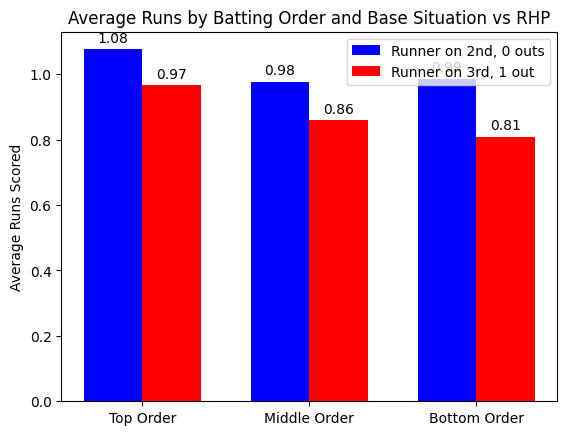

In [88]:
# Visualize data
import matplotlib.pyplot as plt
import numpy as np

# Labels for the scenarios
labels = ['Top Order', 'Middle Order', 'Bottom Order']

# Runs with runner on 2nd, 0 outs
runner_on_2nd = [s1_avg_runs, s3_avg_runs, s5_avg_runs]

# Runs with runner on 3rd, 1 out
runner_on_3rd = [s2_avg_runs, s4_avg_runs, s6_avg_runs]

# X locations for the groups
x = np.arange(len(labels))
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, runner_on_2nd, width, label='Runner on 2nd, 0 outs', color='blue')
bars2 = ax.bar(x + width/2, runner_on_3rd, width, label='Runner on 3rd, 1 out', color='red')

# Labels and formatting
ax.set_ylabel('Average Runs Scored')
ax.set_title('Average Runs by Batting Order and Base Situation vs RHP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add bar labels
ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)

plt.show()

vs LHP

In [89]:
"""
s1 - Top the order, 0 outs, man on second
s2 - Top the order, 1 out, man on third
s3 - 4th in batting order, 0 outs, runner on second base
s4 - 4th in batting order, 1 out, runner on third base
s5 - 7th in batting order, 0 outs, runner on second base
s6 - 7th in batting order, 1 out, runner on third base
"""


# Set number of trials
num_trials = 10000

# Simulate Top the order, 0 outs, man on second
total_sum = 0
for i in range(num_trials):
  total_sum += left_hander_sim_no_print(1, 1, phillies_lineup_lhp, 0, False, True, False)
  s1_avg_runs = total_sum / num_trials

# Simulate Top the order, 1 out, man on third
total_sum = 0
for i in range(num_trials):
  total_sum += left_hander_sim_no_print(1, 1, phillies_lineup_lhp, 1, False, False, True)
  s2_avg_runs = total_sum / num_trials

# Simulate middle of batting order, 0 outs, runner on second base
total_sum = 0
for i in range(num_trials):
  total_sum += left_hander_sim_no_print(1, 4, phillies_lineup_lhp, 0, False, True, False)
  s3_avg_runs = total_sum / num_trials

# Simulate middle of batting order, 1 out, runner on third base
total_sum = 0
for i in range(num_trials):
  total_sum += left_hander_sim_no_print(1, 4, phillies_lineup_lhp, 1, False, False, True)
  s4_avg_runs = total_sum / num_trials

# Simulate bottom of batting order, 0 outs, runner on second base
total_sum = 0
for i in range(num_trials):
  total_sum += left_hander_sim_no_print(1, 7, phillies_lineup_lhp, 0, False, True, False)
  s5_avg_runs = total_sum / num_trials

# Simulate bottom of batting order, 1 out, runner on third base
total_sum = 0
for i in range(num_trials):
  total_sum += left_hander_sim_no_print(1, 7, phillies_lineup_lhp, 1, False, False, True)
  s6_avg_runs = total_sum / num_trials

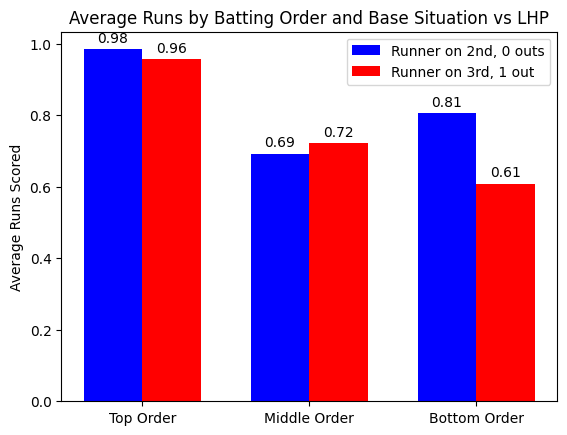

In [90]:
# Visualize data
import matplotlib.pyplot as plt
import numpy as np

# Labels for the scenarios
labels = ['Top Order', 'Middle Order', 'Bottom Order']

# Runs with runner on 2nd, 0 outs
runner_on_2nd = [s1_avg_runs, s3_avg_runs, s5_avg_runs]

# Runs with runner on 3rd, 1 out
runner_on_3rd = [s2_avg_runs, s4_avg_runs, s6_avg_runs]

# X locations for the groups
x = np.arange(len(labels))
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, runner_on_2nd, width, label='Runner on 2nd, 0 outs', color='blue')
bars2 = ax.bar(x + width/2, runner_on_3rd, width, label='Runner on 3rd, 1 out', color='red')

# Labels and formatting
ax.set_ylabel('Average Runs Scored')
ax.set_title('Average Runs by Batting Order and Base Situation vs LHP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add bar labels
ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)

plt.show()